In [2]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/DICOM/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install pydicom

     |████████████████████████████████| 35.1MB 89kB/s 


In [0]:
# !unzip -q Images.zip -d Images_1/
# !ls Images/Images/ -1 | wc -l
# !ls Images_1/ -1 | wc -l

1


In [0]:
import pydicom as dicom
import os
import shutil
import numpy
import pandas as pd
from matplotlib import pyplot as plt, image
import seaborn as sns
import cv2
from IPython.display import display, Image

# Image Dataset preparation

In [0]:
meta_info = pd.read_csv('Meta_Info.csv', usecols=['File Name', 'Response'])
meta_info['File Name'] = meta_info['File Name'].apply(lambda x: x + '.jpg')
print(meta_info.shape)

meta_info.head()

(102449, 2)


,File Name,Response
0,QIN-BREAST-01-0001_000.jpg,non-pCR
1,QIN-BREAST-01-0001_001.jpg,non-pCR
2,QIN-BREAST-01-0001_002.jpg,non-pCR
3,QIN-BREAST-01-0001_003.jpg,non-pCR
4,QIN-BREAST-01-0001_004.jpg,non-pCR


In [0]:
# meta_info[meta_info['File Name'].str.contains('_999.jpg')]
unlabelled_data = meta_info[meta_info['Response'] == 'None']
unlabelled_data.head()

,File Name,Response
95421,QIN-BREAST-01-0060_000.jpg,None
95422,QIN-BREAST-01-0060_001.jpg,None
95423,QIN-BREAST-01-0060_002.jpg,None
95424,QIN-BREAST-01-0060_003.jpg,None
95425,QIN-BREAST-01-0060_004.jpg,None


In [0]:
meta_info = meta_info[meta_info['Response'] != 'None']
meta_info.head()

,File Name,Response
0,QIN-BREAST-01-0001_000.jpg,non-pCR
1,QIN-BREAST-01-0001_001.jpg,non-pCR
2,QIN-BREAST-01-0001_002.jpg,non-pCR
3,QIN-BREAST-01-0001_003.jpg,non-pCR
4,QIN-BREAST-01-0001_004.jpg,non-pCR


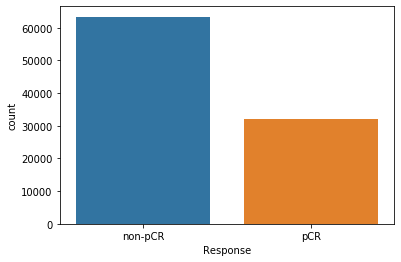

In [0]:
sns.countplot(meta_info['Response']);

> Dataset is Imbalanced.

In [0]:
# ============ Test Data reserved -> Patients 58 (pCR) and 59 (non-pCR)
# ============ Train/Validation Split -> 70/30
train_data = meta_info.iloc[:92189]
validation_data = train_data.sample(frac=0.3, random_state=42)
test_data = meta_info.iloc[92189:]

print(f"Train Data -> {train_data.shape[0] - validation_data.shape[0]}")
print(f"Validation Data -> {validation_data.shape[0]}")
print(f"Test Data -> {test_data.shape[0]}")
print(f"Unlabelled Data -> {unlabelled_data.shape[0]}")

Train Data -> 64532
Validation Data -> 27657
Test Data -> 3232
Unlabelled Data -> 7028


In [0]:
!ls "Images/Unlabelled Images" -1 | wc -l

7028


In [0]:
%%time
src = 'Images'
dest = 'Images/Unlabelled Images'
for _,row in unlabelled_data.iterrows():
    file_name = row['File Name']
    response = row['Response']
    shutil.move(f'{src}/{file_name}', f'{dest}/{file_name}')

CPU times: user 2.18 s, sys: 498 ms, total: 2.68 s
Wall time: 2min 13s


In [0]:
%%time
files_not_found = []
def move_imgs(dest, data):
    src = 'Images'
    for _,row in data.iterrows():
        file_name = row['File Name']
        response = row['Response']
        try:
            shutil.move(f'{src}/{file_name}', f'{src}/{dest}/{response}/{file_name}')
        except FileNotFoundError as err:
            files_not_found.append(file_name)

move_imgs('Test Images', test_data)
# move_imgs('Validation Images', validation_data)
# move_imgs('Train Images', train_data)

CPU times: user 1.58 s, sys: 925 ms, total: 2.5 s
Wall time: 46.4 s


# Model Building (From Kaggle)

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import shutil

# base_path = '/kaggle/input/'
# print(os.listdir('/kaggle/input'))

def show_counts():
    print(f"# Unlabelled Images -> {len(os.listdir('/kaggle/input/Images/Unlabelled Images'))}")
    print(f"# Train Images -> {len(os.listdir('/kaggle/input/Images/Train Images/pCR'))}, {len(os.listdir('/kaggle/input/Images/Train Images/non-pCR'))}")
    print(f"# Validation Images -> {len(os.listdir('/kaggle/input/Images/Validation Images/pCR'))}, {len(os.listdir('/kaggle/input/Images/Validation Images/non-pCR'))}")
    print(f"# Test Images -> {len(os.listdir('/kaggle/input/Images/Test Images/pCR'))}, {len(os.listdir('/kaggle/input/Images/Test Images/non-pCR'))}")

def create_balance(path='/kaggle/input/Images/Train Images/pCR'):
    files = os.listdir(path)
    for file in files:
        shutil.copy(f'{path}/{file}', f'{path}/Copy_{file}')
        if len(os.listdir(path)) >= 43206:
            break
    num_copies = len([x for x in os.listdir(path) if x.startswith('Copy_')])
    print(f"No. of Copies created -> {num_copies}")

print(f"Before Balancing ::\n{'='*60}")
show_counts()
# create_balance()
# print(f"After Balancing ::\n{'='*60}")
# show_counts()

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.



### Output ::
#Before Balancing ::
#============================================================
# Unlabelled Images -> 7028
# Train Images -> 21326, 43206
# Validation Images -> 9112, 18545
# Test Images -> 1616, 1616

In [0]:
import shutil
import random
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import glob
from tqdm import tqdm
import pickle

import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet_v2 import ResNet50V2, ResNet152V2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from keras.models import Model,load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
base_path = '/kaggle/input/Images'

# Create Train and Test Data Generators
train_datagen = ImageDataGenerator(
#                 featurewise_center=False,
#                 featurewise_std_normalization=False,
#                 rotation_range=40,
#                 shear_range=0.3,
#                 zoom_range=0.2,
#                 width_shift_range=0.2,
#                 height_shift_range=0.2,
#                 fill_mode="nearest",
#                 horizontal_flip=True,
#                 vertical_flip=True,
                rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(f'{base_path}/Train Images',
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(f'{base_path}/Validation Images',
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  batch_size=20,
                                                  class_mode='binary',
                                                  shuffle=True)

print(train_generator.class_indices)


### Output ::
# Found 64532 images belonging to 2 classes.
# Found 27657 images belonging to 2 classes.
# {'non-pCR': 0, 'pCR': 1}

In [0]:
%%time

# Destroy the current TF graph and create a new one and create callbacks to be used later.
K.clear_session()
check_point = ModelCheckpoint('best_model.hdf5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5, mode='max')

def get_model():
    # Create the Base Model and add layers from the Output of the same.
    base_model = ResNet50V2(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2048)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    preds = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=preds)

    # Make the first 50 layers non-trainable
#     for layer in model.layers[:50]:
#         layer.trainable=False

    return model

# def get_basic_model():
#     inp = Input(shape=(299, 299, 3))
#     x = Conv2D(128, (3, 3), padding="same", activation="relu")(inp)
#     x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
#     x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
#     x = MaxPooling2D((2, 2))(x)

#     x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
#     x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
#     x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
#     x = MaxPooling2D((2, 2))(x)

#     x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
#     x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
#     x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
#     x = MaxPooling2D((2, 2))(x)

#     x = Flatten()(x)
#     x = Dense(2048)(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(0.5)(x)

#     x = Dense(1024)(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(0.5)(x)

#     x = Dense(512)(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(0.5)(x)

#     preds = Dense(1, activation='sigmoid')(x)
#     model = Model(inputs=inp, outputs=preds)
#     return model

model = get_model()
# model = get_basic_model()
print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(generator=train_generator,
                        validation_data=validation_generator,
                        class_weight={0: 1.0, 1: 2.2},
                        use_multiprocessing=True, workers=2,
                        steps_per_epoch=1000,
                        epochs=20, verbose=2,
                        callbacks=[check_point, early_stopping])

### Model Summary

In [0]:
# Model: "model_1"
# __________________________________________________________________________________________________
# Layer (type)                    Output Shape         Param #     Connected to                     
# ==================================================================================================
# input_1 (InputLayer)            (None, None, None, 3 0                                            
# __________________________________________________________________________________________________
# conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
# __________________________________________________________________________________________________
# conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
# __________________________________________________________________________________________________
# pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
# __________________________________________________________________________________________________
# pool1_pool (MaxPooling2D)       (None, None, None, 6 0           pool1_pad[0][0]                  
# __________________________________________________________________________________________________
# conv2_block1_preact_bn (BatchNo (None, None, None, 6 256         pool1_pool[0][0]                 
# __________________________________________________________________________________________________
# conv2_block1_preact_relu (Activ (None, None, None, 6 0           conv2_block1_preact_bn[0][0]     
# __________________________________________________________________________________________________
# conv2_block1_1_conv (Conv2D)    (None, None, None, 6 4096        conv2_block1_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv2_block1_1_bn (BatchNormali (None, None, None, 6 256         conv2_block1_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block1_1_relu (Activation (None, None, None, 6 0           conv2_block1_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block1_2_pad (ZeroPadding (None, None, None, 6 0           conv2_block1_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block1_2_conv (Conv2D)    (None, None, None, 6 36864       conv2_block1_2_pad[0][0]         
# __________________________________________________________________________________________________
# conv2_block1_2_bn (BatchNormali (None, None, None, 6 256         conv2_block1_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block1_2_relu (Activation (None, None, None, 6 0           conv2_block1_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block1_0_conv (Conv2D)    (None, None, None, 2 16640       conv2_block1_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv2_block1_3_conv (Conv2D)    (None, None, None, 2 16640       conv2_block1_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block1_out (Add)          (None, None, None, 2 0           conv2_block1_0_conv[0][0]        
#                                                                  conv2_block1_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block2_preact_bn (BatchNo (None, None, None, 2 1024        conv2_block1_out[0][0]           
# __________________________________________________________________________________________________
# conv2_block2_preact_relu (Activ (None, None, None, 2 0           conv2_block2_preact_bn[0][0]     
# __________________________________________________________________________________________________
# conv2_block2_1_conv (Conv2D)    (None, None, None, 6 16384       conv2_block2_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv2_block2_1_bn (BatchNormali (None, None, None, 6 256         conv2_block2_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block2_1_relu (Activation (None, None, None, 6 0           conv2_block2_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block2_2_pad (ZeroPadding (None, None, None, 6 0           conv2_block2_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block2_2_conv (Conv2D)    (None, None, None, 6 36864       conv2_block2_2_pad[0][0]         
# __________________________________________________________________________________________________
# conv2_block2_2_bn (BatchNormali (None, None, None, 6 256         conv2_block2_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block2_2_relu (Activation (None, None, None, 6 0           conv2_block2_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block2_3_conv (Conv2D)    (None, None, None, 2 16640       conv2_block2_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block2_out (Add)          (None, None, None, 2 0           conv2_block1_out[0][0]           
#                                                                  conv2_block2_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block3_preact_bn (BatchNo (None, None, None, 2 1024        conv2_block2_out[0][0]           
# __________________________________________________________________________________________________
# conv2_block3_preact_relu (Activ (None, None, None, 2 0           conv2_block3_preact_bn[0][0]     
# __________________________________________________________________________________________________
# conv2_block3_1_conv (Conv2D)    (None, None, None, 6 16384       conv2_block3_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv2_block3_1_bn (BatchNormali (None, None, None, 6 256         conv2_block3_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block3_1_relu (Activation (None, None, None, 6 0           conv2_block3_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv2_block3_2_pad (ZeroPadding (None, None, None, 6 0           conv2_block3_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block3_2_conv (Conv2D)    (None, None, None, 6 36864       conv2_block3_2_pad[0][0]         
# __________________________________________________________________________________________________
# conv2_block3_2_bn (BatchNormali (None, None, None, 6 256         conv2_block3_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv2_block3_2_relu (Activation (None, None, None, 6 0           conv2_block3_2_bn[0][0]          
# __________________________________________________________________________________________________
# max_pooling2d_1 (MaxPooling2D)  (None, None, None, 2 0           conv2_block2_out[0][0]           
# __________________________________________________________________________________________________
# conv2_block3_3_conv (Conv2D)    (None, None, None, 2 16640       conv2_block3_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv2_block3_out (Add)          (None, None, None, 2 0           max_pooling2d_1[0][0]            
#                                                                  conv2_block3_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_preact_bn (BatchNo (None, None, None, 2 1024        conv2_block3_out[0][0]           
# __________________________________________________________________________________________________
# conv3_block1_preact_relu (Activ (None, None, None, 2 0           conv3_block1_preact_bn[0][0]     
# __________________________________________________________________________________________________
# conv3_block1_1_conv (Conv2D)    (None, None, None, 1 32768       conv3_block1_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv3_block1_1_bn (BatchNormali (None, None, None, 1 512         conv3_block1_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_1_relu (Activation (None, None, None, 1 0           conv3_block1_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block1_2_pad (ZeroPadding (None, None, None, 1 0           conv3_block1_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_2_conv (Conv2D)    (None, None, None, 1 147456      conv3_block1_2_pad[0][0]         
# __________________________________________________________________________________________________
# conv3_block1_2_bn (BatchNormali (None, None, None, 1 512         conv3_block1_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_2_relu (Activation (None, None, None, 1 0           conv3_block1_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block1_0_conv (Conv2D)    (None, None, None, 5 131584      conv3_block1_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv3_block1_3_conv (Conv2D)    (None, None, None, 5 66048       conv3_block1_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block1_out (Add)          (None, None, None, 5 0           conv3_block1_0_conv[0][0]        
#                                                                  conv3_block1_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block2_preact_bn (BatchNo (None, None, None, 5 2048        conv3_block1_out[0][0]           
# __________________________________________________________________________________________________
# conv3_block2_preact_relu (Activ (None, None, None, 5 0           conv3_block2_preact_bn[0][0]     
# __________________________________________________________________________________________________
# conv3_block2_1_conv (Conv2D)    (None, None, None, 1 65536       conv3_block2_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv3_block2_1_bn (BatchNormali (None, None, None, 1 512         conv3_block2_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block2_1_relu (Activation (None, None, None, 1 0           conv3_block2_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block2_2_pad (ZeroPadding (None, None, None, 1 0           conv3_block2_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block2_2_conv (Conv2D)    (None, None, None, 1 147456      conv3_block2_2_pad[0][0]         
# __________________________________________________________________________________________________
# conv3_block2_2_bn (BatchNormali (None, None, None, 1 512         conv3_block2_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block2_2_relu (Activation (None, None, None, 1 0           conv3_block2_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block2_3_conv (Conv2D)    (None, None, None, 5 66048       conv3_block2_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block2_out (Add)          (None, None, None, 5 0           conv3_block1_out[0][0]           
#                                                                  conv3_block2_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block3_preact_bn (BatchNo (None, None, None, 5 2048        conv3_block2_out[0][0]           
# __________________________________________________________________________________________________
# conv3_block3_preact_relu (Activ (None, None, None, 5 0           conv3_block3_preact_bn[0][0]     
# __________________________________________________________________________________________________
# conv3_block3_1_conv (Conv2D)    (None, None, None, 1 65536       conv3_block3_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv3_block3_1_bn (BatchNormali (None, None, None, 1 512         conv3_block3_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block3_1_relu (Activation (None, None, None, 1 0           conv3_block3_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block3_2_pad (ZeroPadding (None, None, None, 1 0           conv3_block3_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block3_2_conv (Conv2D)    (None, None, None, 1 147456      conv3_block3_2_pad[0][0]         
# __________________________________________________________________________________________________
# conv3_block3_2_bn (BatchNormali (None, None, None, 1 512         conv3_block3_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block3_2_relu (Activation (None, None, None, 1 0           conv3_block3_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block3_3_conv (Conv2D)    (None, None, None, 5 66048       conv3_block3_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block3_out (Add)          (None, None, None, 5 0           conv3_block2_out[0][0]           
#                                                                  conv3_block3_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block4_preact_bn (BatchNo (None, None, None, 5 2048        conv3_block3_out[0][0]           
# __________________________________________________________________________________________________
# conv3_block4_preact_relu (Activ (None, None, None, 5 0           conv3_block4_preact_bn[0][0]     
# __________________________________________________________________________________________________
# conv3_block4_1_conv (Conv2D)    (None, None, None, 1 65536       conv3_block4_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv3_block4_1_bn (BatchNormali (None, None, None, 1 512         conv3_block4_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block4_1_relu (Activation (None, None, None, 1 0           conv3_block4_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv3_block4_2_pad (ZeroPadding (None, None, None, 1 0           conv3_block4_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block4_2_conv (Conv2D)    (None, None, None, 1 147456      conv3_block4_2_pad[0][0]         
# __________________________________________________________________________________________________
# conv3_block4_2_bn (BatchNormali (None, None, None, 1 512         conv3_block4_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv3_block4_2_relu (Activation (None, None, None, 1 0           conv3_block4_2_bn[0][0]          
# __________________________________________________________________________________________________
# max_pooling2d_2 (MaxPooling2D)  (None, None, None, 5 0           conv3_block3_out[0][0]           
# __________________________________________________________________________________________________
# conv3_block4_3_conv (Conv2D)    (None, None, None, 5 66048       conv3_block4_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv3_block4_out (Add)          (None, None, None, 5 0           max_pooling2d_2[0][0]            
#                                                                  conv3_block4_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_preact_bn (BatchNo (None, None, None, 5 2048        conv3_block4_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block1_preact_relu (Activ (None, None, None, 5 0           conv4_block1_preact_bn[0][0]     
# __________________________________________________________________________________________________
# conv4_block1_1_conv (Conv2D)    (None, None, None, 2 131072      conv4_block1_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv4_block1_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block1_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_1_relu (Activation (None, None, None, 2 0           conv4_block1_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block1_2_pad (ZeroPadding (None, None, None, 2 0           conv4_block1_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_2_conv (Conv2D)    (None, None, None, 2 589824      conv4_block1_2_pad[0][0]         
# __________________________________________________________________________________________________
# conv4_block1_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block1_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_2_relu (Activation (None, None, None, 2 0           conv4_block1_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block1_0_conv (Conv2D)    (None, None, None, 1 525312      conv4_block1_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv4_block1_3_conv (Conv2D)    (None, None, None, 1 263168      conv4_block1_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block1_out (Add)          (None, None, None, 1 0           conv4_block1_0_conv[0][0]        
#                                                                  conv4_block1_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block2_preact_bn (BatchNo (None, None, None, 1 4096        conv4_block1_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block2_preact_relu (Activ (None, None, None, 1 0           conv4_block2_preact_bn[0][0]     
# __________________________________________________________________________________________________
# conv4_block2_1_conv (Conv2D)    (None, None, None, 2 262144      conv4_block2_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv4_block2_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block2_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block2_1_relu (Activation (None, None, None, 2 0           conv4_block2_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block2_2_pad (ZeroPadding (None, None, None, 2 0           conv4_block2_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block2_2_conv (Conv2D)    (None, None, None, 2 589824      conv4_block2_2_pad[0][0]         
# __________________________________________________________________________________________________
# conv4_block2_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block2_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block2_2_relu (Activation (None, None, None, 2 0           conv4_block2_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block2_3_conv (Conv2D)    (None, None, None, 1 263168      conv4_block2_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block2_out (Add)          (None, None, None, 1 0           conv4_block1_out[0][0]           
#                                                                  conv4_block2_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block3_preact_bn (BatchNo (None, None, None, 1 4096        conv4_block2_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block3_preact_relu (Activ (None, None, None, 1 0           conv4_block3_preact_bn[0][0]     
# __________________________________________________________________________________________________
# conv4_block3_1_conv (Conv2D)    (None, None, None, 2 262144      conv4_block3_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv4_block3_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block3_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block3_1_relu (Activation (None, None, None, 2 0           conv4_block3_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block3_2_pad (ZeroPadding (None, None, None, 2 0           conv4_block3_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block3_2_conv (Conv2D)    (None, None, None, 2 589824      conv4_block3_2_pad[0][0]         
# __________________________________________________________________________________________________
# conv4_block3_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block3_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block3_2_relu (Activation (None, None, None, 2 0           conv4_block3_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block3_3_conv (Conv2D)    (None, None, None, 1 263168      conv4_block3_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block3_out (Add)          (None, None, None, 1 0           conv4_block2_out[0][0]           
#                                                                  conv4_block3_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block4_preact_bn (BatchNo (None, None, None, 1 4096        conv4_block3_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block4_preact_relu (Activ (None, None, None, 1 0           conv4_block4_preact_bn[0][0]     
# __________________________________________________________________________________________________
# conv4_block4_1_conv (Conv2D)    (None, None, None, 2 262144      conv4_block4_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv4_block4_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block4_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block4_1_relu (Activation (None, None, None, 2 0           conv4_block4_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block4_2_pad (ZeroPadding (None, None, None, 2 0           conv4_block4_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block4_2_conv (Conv2D)    (None, None, None, 2 589824      conv4_block4_2_pad[0][0]         
# __________________________________________________________________________________________________
# conv4_block4_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block4_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block4_2_relu (Activation (None, None, None, 2 0           conv4_block4_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block4_3_conv (Conv2D)    (None, None, None, 1 263168      conv4_block4_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block4_out (Add)          (None, None, None, 1 0           conv4_block3_out[0][0]           
#                                                                  conv4_block4_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block5_preact_bn (BatchNo (None, None, None, 1 4096        conv4_block4_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block5_preact_relu (Activ (None, None, None, 1 0           conv4_block5_preact_bn[0][0]     
# __________________________________________________________________________________________________
# conv4_block5_1_conv (Conv2D)    (None, None, None, 2 262144      conv4_block5_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv4_block5_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block5_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block5_1_relu (Activation (None, None, None, 2 0           conv4_block5_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block5_2_pad (ZeroPadding (None, None, None, 2 0           conv4_block5_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block5_2_conv (Conv2D)    (None, None, None, 2 589824      conv4_block5_2_pad[0][0]         
# __________________________________________________________________________________________________
# conv4_block5_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block5_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block5_2_relu (Activation (None, None, None, 2 0           conv4_block5_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block5_3_conv (Conv2D)    (None, None, None, 1 263168      conv4_block5_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block5_out (Add)          (None, None, None, 1 0           conv4_block4_out[0][0]           
#                                                                  conv4_block5_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block6_preact_bn (BatchNo (None, None, None, 1 4096        conv4_block5_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block6_preact_relu (Activ (None, None, None, 1 0           conv4_block6_preact_bn[0][0]     
# __________________________________________________________________________________________________
# conv4_block6_1_conv (Conv2D)    (None, None, None, 2 262144      conv4_block6_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv4_block6_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block6_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block6_1_relu (Activation (None, None, None, 2 0           conv4_block6_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv4_block6_2_pad (ZeroPadding (None, None, None, 2 0           conv4_block6_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block6_2_conv (Conv2D)    (None, None, None, 2 589824      conv4_block6_2_pad[0][0]         
# __________________________________________________________________________________________________
# conv4_block6_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block6_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv4_block6_2_relu (Activation (None, None, None, 2 0           conv4_block6_2_bn[0][0]          
# __________________________________________________________________________________________________
# max_pooling2d_3 (MaxPooling2D)  (None, None, None, 1 0           conv4_block5_out[0][0]           
# __________________________________________________________________________________________________
# conv4_block6_3_conv (Conv2D)    (None, None, None, 1 263168      conv4_block6_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv4_block6_out (Add)          (None, None, None, 1 0           max_pooling2d_3[0][0]            
#                                                                  conv4_block6_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_preact_bn (BatchNo (None, None, None, 1 4096        conv4_block6_out[0][0]           
# __________________________________________________________________________________________________
# conv5_block1_preact_relu (Activ (None, None, None, 1 0           conv5_block1_preact_bn[0][0]     
# __________________________________________________________________________________________________
# conv5_block1_1_conv (Conv2D)    (None, None, None, 5 524288      conv5_block1_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv5_block1_1_bn (BatchNormali (None, None, None, 5 2048        conv5_block1_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_1_relu (Activation (None, None, None, 5 0           conv5_block1_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block1_2_pad (ZeroPadding (None, None, None, 5 0           conv5_block1_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_2_conv (Conv2D)    (None, None, None, 5 2359296     conv5_block1_2_pad[0][0]         
# __________________________________________________________________________________________________
# conv5_block1_2_bn (BatchNormali (None, None, None, 5 2048        conv5_block1_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_2_relu (Activation (None, None, None, 5 0           conv5_block1_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block1_0_conv (Conv2D)    (None, None, None, 2 2099200     conv5_block1_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv5_block1_3_conv (Conv2D)    (None, None, None, 2 1050624     conv5_block1_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block1_out (Add)          (None, None, None, 2 0           conv5_block1_0_conv[0][0]        
#                                                                  conv5_block1_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block2_preact_bn (BatchNo (None, None, None, 2 8192        conv5_block1_out[0][0]           
# __________________________________________________________________________________________________
# conv5_block2_preact_relu (Activ (None, None, None, 2 0           conv5_block2_preact_bn[0][0]     
# __________________________________________________________________________________________________
# conv5_block2_1_conv (Conv2D)    (None, None, None, 5 1048576     conv5_block2_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv5_block2_1_bn (BatchNormali (None, None, None, 5 2048        conv5_block2_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block2_1_relu (Activation (None, None, None, 5 0           conv5_block2_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block2_2_pad (ZeroPadding (None, None, None, 5 0           conv5_block2_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block2_2_conv (Conv2D)    (None, None, None, 5 2359296     conv5_block2_2_pad[0][0]         
# __________________________________________________________________________________________________
# conv5_block2_2_bn (BatchNormali (None, None, None, 5 2048        conv5_block2_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block2_2_relu (Activation (None, None, None, 5 0           conv5_block2_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block2_3_conv (Conv2D)    (None, None, None, 2 1050624     conv5_block2_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block2_out (Add)          (None, None, None, 2 0           conv5_block1_out[0][0]           
#                                                                  conv5_block2_3_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block3_preact_bn (BatchNo (None, None, None, 2 8192        conv5_block2_out[0][0]           
# __________________________________________________________________________________________________
# conv5_block3_preact_relu (Activ (None, None, None, 2 0           conv5_block3_preact_bn[0][0]     
# __________________________________________________________________________________________________
# conv5_block3_1_conv (Conv2D)    (None, None, None, 5 1048576     conv5_block3_preact_relu[0][0]   
# __________________________________________________________________________________________________
# conv5_block3_1_bn (BatchNormali (None, None, None, 5 2048        conv5_block3_1_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block3_1_relu (Activation (None, None, None, 5 0           conv5_block3_1_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block3_2_pad (ZeroPadding (None, None, None, 5 0           conv5_block3_1_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block3_2_conv (Conv2D)    (None, None, None, 5 2359296     conv5_block3_2_pad[0][0]         
# __________________________________________________________________________________________________
# conv5_block3_2_bn (BatchNormali (None, None, None, 5 2048        conv5_block3_2_conv[0][0]        
# __________________________________________________________________________________________________
# conv5_block3_2_relu (Activation (None, None, None, 5 0           conv5_block3_2_bn[0][0]          
# __________________________________________________________________________________________________
# conv5_block3_3_conv (Conv2D)    (None, None, None, 2 1050624     conv5_block3_2_relu[0][0]        
# __________________________________________________________________________________________________
# conv5_block3_out (Add)          (None, None, None, 2 0           conv5_block2_out[0][0]           
#                                                                  conv5_block3_3_conv[0][0]        
# __________________________________________________________________________________________________
# post_bn (BatchNormalization)    (None, None, None, 2 8192        conv5_block3_out[0][0]           
# __________________________________________________________________________________________________
# post_relu (Activation)          (None, None, None, 2 0           post_bn[0][0]                    
# __________________________________________________________________________________________________
# global_average_pooling2d_1 (Glo (None, 2048)         0           post_relu[0][0]                  
# __________________________________________________________________________________________________
# dense_1 (Dense)                 (None, 2048)         4196352     global_average_pooling2d_1[0][0] 
# __________________________________________________________________________________________________
# batch_normalization_1 (BatchNor (None, 2048)         8192        dense_1[0][0]                    
# __________________________________________________________________________________________________
# activation_1 (Activation)       (None, 2048)         0           batch_normalization_1[0][0]      
# __________________________________________________________________________________________________
# dropout_1 (Dropout)             (None, 2048)         0           activation_1[0][0]               
# __________________________________________________________________________________________________
# dense_2 (Dense)                 (None, 1024)         2098176     dropout_1[0][0]                  
# __________________________________________________________________________________________________
# batch_normalization_2 (BatchNor (None, 1024)         4096        dense_2[0][0]                    
# __________________________________________________________________________________________________
# activation_2 (Activation)       (None, 1024)         0           batch_normalization_2[0][0]      
# __________________________________________________________________________________________________
# dropout_2 (Dropout)             (None, 1024)         0           activation_2[0][0]               
# __________________________________________________________________________________________________
# dense_3 (Dense)                 (None, 512)          524800      dropout_2[0][0]                  
# __________________________________________________________________________________________________
# batch_normalization_3 (BatchNor (None, 512)          2048        dense_3[0][0]                    
# __________________________________________________________________________________________________
# activation_3 (Activation)       (None, 512)          0           batch_normalization_3[0][0]      
# __________________________________________________________________________________________________
# dropout_3 (Dropout)             (None, 512)          0           activation_3[0][0]               
# __________________________________________________________________________________________________
# dense_4 (Dense)                 (None, 1)            513         dropout_3[0][0]                  
# ==================================================================================================
# Total params: 30,398,977
# Trainable params: 30,346,369
# Non-trainable params: 52,608
# __________________________________________________________________________________________________
# None

### Plots

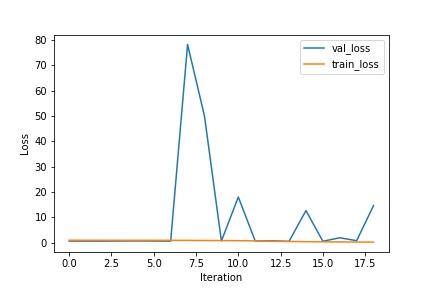

In [3]:
# Plot the performance of the model
# plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='val_loss')
# plt.plot(range(len(history.history['loss'])), history.history['loss'], label='train_loss')
# plt.legend()
# plt.ylabel('Loss')
# plt.xlabel('Iteration')
# plt.savefig('Loss.jpg');
display(Image(filename='Loss.jpg'))

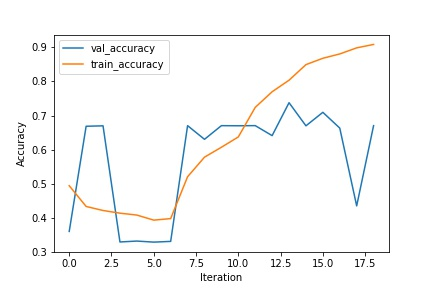

In [4]:
# Plot the performance of the model
# plt.plot(range(len(history.history['accuracy'])), history.history['val_accuracy'], label='val_accuracy')
# plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='train_accuracy')
# plt.legend()
# plt.ylabel('Accuracy')
# plt.xlabel('Iteration')
# plt.savefig('Accuracy.jpg');
display(Image(filename='Accuracy.jpg'))

In [0]:
%%time
test_generator = validation_datagen.flow_from_directory(f'{base_path}/Test Images',
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  batch_size=20,
                                                  class_mode='binary',
                                                  shuffle=False)

best_model = load_model('best_model.hdf5')
y_true = test_generator.classes
y_pred = best_model.predict_generator(generator=test_generator, verbose=1)
y_hat = y_pred > 0.5
print("Accuracy:", accuracy_score(y_true, y_hat), "\n")
print("F1-Score:", f1_score(y_true, y_hat), "\n")
print("Classification Report:\n", classification_report(y_true, y_hat), "\n")
print("Confusion Matrix:\n", confusion_matrix(y_true, y_hat))

### Output ::
# Found 3232 images belonging to 2 classes.
# 162/162 [==============================] - 15s 92ms/step
# Accuracy: 0.5148514851485149 

# F1-Score: 0.05995203836930455 

# Classification Report:
#                precision    recall  f1-score   support

#            0       0.51      1.00      0.67      1616
#            1       0.96      0.03      0.06      1616

#     accuracy                           0.51      3232
#    macro avg       0.73      0.51      0.37      3232
# weighted avg       0.73      0.51      0.37      3232
 

# Confusion Matrix:
#  [[1614    2]
#  [1566   50]]
# CPU times: user 46 s, sys: 3.61 s, total: 49.6 s
# Wall time: 43.1 s

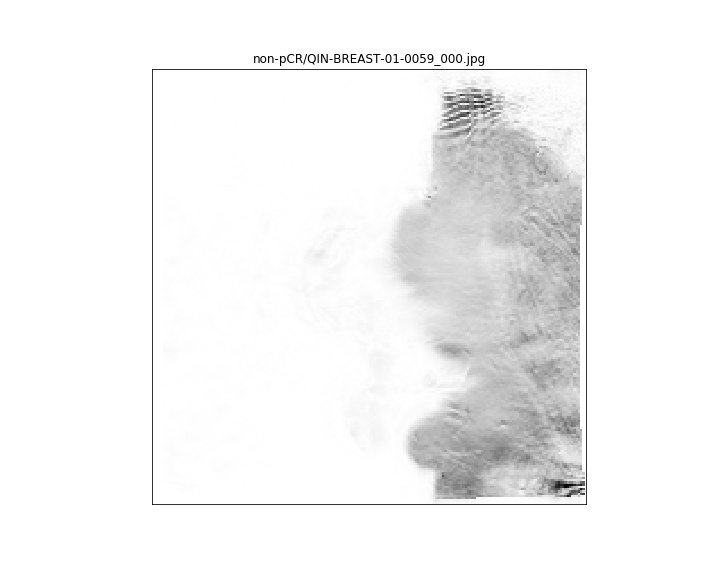

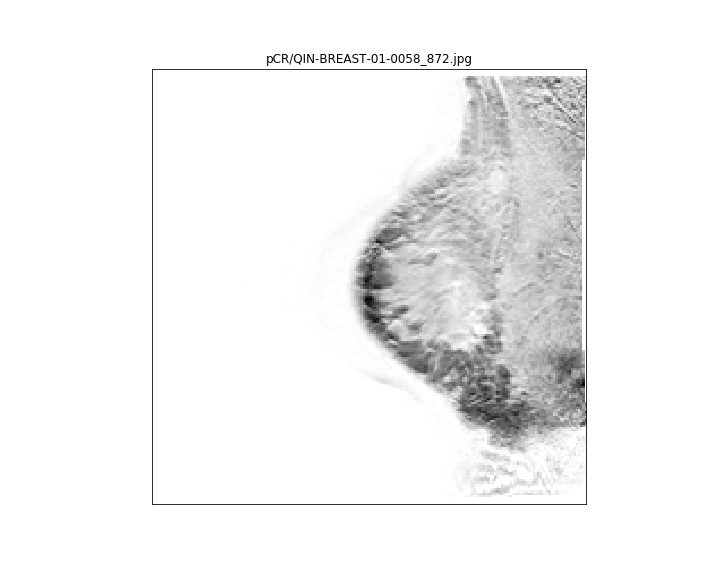

In [5]:
# temp_path = '/kaggle/input/Images/Test Images'
# def display_pred(file, label):
#     plt.figure(figsize=(10, 8))
#     plt.imshow(plt.imread(f'{temp_path}/{label}/{file}'))
#     plt.xticks([])
#     plt.yticks([])
#     plt.title(f'{label}/{file}')
#     plt.savefig(f'Pred_{label}.jpg')
#     plt.show()
    
#     image = load_img(f'{temp_path}/{label}/{file}', target_size=(224, 224))
#     image = img_to_array(image)
#     image *= 1./255
    
#     pred = best_model.predict([[image]], batch_size=1)
#     pred_label = 'non-pCR' if pred[0][0] < 0.5 else 'pCR'
#     print(f"Actual Label -> {label}")
#     print(f"Predicted Label -> {pred_label}")
#     print(f"Prediction Score -> {pred[0][0]}")
    
# display_pred('QIN-BREAST-01-0059_000.jpg', 'non-pCR')

### Ouput ::
# Actual Label -> non-pCR
# Predicted Label -> non-pCR
# Prediction Score -> 0.01582050882279873
# display_pred('QIN-BREAST-01-0058_872.jpg', 'pCR')
### Output ::
# Actual Label -> pCR
# Predicted Label -> pCR
# Prediction Score -> 0.8471142053604126

display(Image(filename='Pred_non-pCR.jpg'))
display(Image(filename='Pred_pCR.jpg'))